# Analysis: Ideal Location to Launch an Ice Cream Shop

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will be trying to find an optimal place to open a new ice cream shop. We will be focusing on the famous localities of the city of __Bangalore, India__ to find the best place.

Our study will be based upon the thumb rule that ice cream is most popular among kids and youngsters compare to other age groups. Considering the same, we will try to find out which locality of Bangalore is the best combination of maximum number of schools and least number of ice cream shops (certainly to avoid the competition and make most profit).

Later part we will also try to find the best match with respect to the land price, and check if the obtained result is also falling in your budget. 

This study can be used by any budding business man, who wants to open a new ice cream outlet in the city.

## Data <a name="data"></a>

Based upon the requirement we will be using below data sources for fetching our data:

<li> For fetching the location information of Bangalore city and neighborhood areas we will be using <b>geopy</b> library</li>
<li> For fetching the neighborhoods in the city we will be using data from <b>Citizen Matters</b> website</li>
<li> For fetching the number of schools and number of ice cream shops we will be using <b>Foursquare API</b></li>
<li> For comparing the results with the commercial shop rate we will be using data from <b>Citizen Matters</b> website</li>


## Methodology <a name="methodology"></a>

##### Import Required Libraries

In [2]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

In [3]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    pandas-1.0.3               |   py36h830a2c2_1        11.1 MB  conda-forge
    pysocks-1.7.1              |   py36h9f0ad1d_1          27 KB  conda-

In [4]:
!pip install lxml # for reading html table data

     |████████████████████████████████| 5.8MB 10.0MB/s eta 0:00:01


##### Fetch Neighborhood details
List of neighborhood and their real estate prices will be fetched from __Citizen Matters__ website. This website contains a table to neighborhood/area and details of their Residential rates and Commercial rates.

In [90]:
n_url = 'https://bengaluru.citizenmatters.in/615-real-estate-rates-615'
df_master = pd.read_html(n_url,header=0)

Read the required columns from the table

In [91]:
df_master = pd.DataFrame(df_master[0],columns=["Area","Commercial rates(All numbers in Rs Sq/ft)"]).dropna(axis=0)
df_master.rename(columns={"Commercial rates(All numbers in Rs Sq/ft)":"Commercial_Rates"}, inplace=True)

In [92]:
df_master.head(10)

,Area,Commercial_Rates
0,BLR – Central business Districts,BLR – Central business Districts
1,MG Road,20000
2,Kasturba Rd,15000
4,Church Street,15000
5,Dickenson Rd,12500
6,Ashokanagar,5000
7,Victoria Layout,8000
8,Commercial Street,25000
9,Infantry Rd,15000
10,K Kamraj Rd,5000-8000


In [93]:
df_master.shape

(169, 2)

For some of the areas like 'K Kamraj Rd' have range defined for Commercial Rates. We need to take their average for our further study.

In [94]:
# loop each row and find out which are ranges
for index,row in df_master.iterrows():
      if('-' in row.Commercial_Rates):
        split = row.Commercial_Rates.split('-')
        if(split[0].isnumeric()):
            row.Commercial_Rates = round((int(split[0])+int(split[1]))/2)

In [95]:
# Remove non-numeric/invalid values
df_master['Commercial_Rates'] = pd.to_numeric(df_master['Commercial_Rates'], errors='coerce')
df_master.dropna(axis=0, inplace=True)

In [96]:
df_master.head(10)

,Area,Commercial_Rates
1,MG Road,20000.0
2,Kasturba Rd,15000.0
4,Church Street,15000.0
5,Dickenson Rd,12500.0
6,Ashokanagar,5000.0
7,Victoria Layout,8000.0
8,Commercial Street,25000.0
9,Infantry Rd,15000.0
10,K Kamraj Rd,6500.0
11,Shivajinagar,5000.0


##### Now, let's fetch the longitude and latitude data for each Neighborhood

In [97]:
# Method to get lat, log data 
def get_address(address):
    try:
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        return latitude, longitude
    except:
        return None, None

In [98]:
df_master['Longitude']=""
df_master['Latitude']=""

In [99]:
#loop through each row
for index,row in df_master.iterrows():
    address = row.Area + ",Bangalore"
    lat, log = get_address(address)
    df_master.at[index, 'Longitude']=log
    df_master.at[index, 'Latitude']=lat

In [123]:
#Remove entries for which lat,log info is missing
df_master.dropna(axis=0, inplace=True)

In [125]:
df_master.shape

(118, 4)

In [130]:
# create map of Bangalore using latitude and longitude values
blr_latitude, blr_longitude = get_address('Bangalore, India')

map_blr = folium.Map(location=[blr_latitude, blr_longitude], zoom_start=12)

# add markers to map
for lat, lng, area in zip(df_master['Latitude'], df_master['Longitude'], df_master['Area']):
    label = area
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_blr)  
    
map_blr

### Foursquare

In [131]:
import requests # library to handle requests
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [134]:
CLIENT_ID = 'ZWEX0Z5A2VUOZO3DBFSACOXMWWBNZDYJIAWPQXNPKLBN45VN' # Foursquare ID
CLIENT_SECRET = 'ZS0KM2YPVLN4RDFD15AZLH25F0MVCG1NI1RJZIW3XKA55VJZ' # Foursquare Secret
VERSION = '20180604'

##### We will be querying the venues in the radius of 500 meters around the location

In [143]:
LIMIT = 30
radius = 500
def get_fSquareResult(lat, log, search_query):
    f_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, log, VERSION, search_query, radius, LIMIT)
    results = requests.get(f_url).json()
    return results

#### It's time to fetch the number of schools and the number of ice cream shops in each area

In [158]:
df_master['NoOf_Schools'] =""
df_master['NoOf_IceCreamShops'] =""

#loop through each row
for index,row in df_master.iterrows():
    shops = get_fSquareResult(df_master.at[index,'Latitude'], df_master.at[index,'Longitude'],'Ice Cream')
    schools = get_fSquareResult(df_master.at[index,'Latitude'], df_master.at[index,'Longitude'],'school')
    df_master.at[index, 'NoOf_IceCreamShops']=len(shops['response']['venues'])
    df_master.at[index, 'NoOf_Schools']=len(schools['response']['venues'])


In [160]:
df_master.head(5)

,Area,Commercial_Rates,Longitude,Latitude,NoOf_Schools,NoOf_IceCreamShops
1,MG Road,20000.0,77.6124,12.9742,3,2
2,Kasturba Rd,15000.0,77.5993,12.9767,3,7
4,Church Street,15000.0,77.6525,12.9743,4,0
5,Dickenson Rd,12500.0,77.6107,12.9809,3,1
6,Ashokanagar,5000.0,77.5646,12.9377,5,1


##### This data gives us a fair idea of how the count of schools is in ratio with number of ice cream shops in that region.

In [161]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

In [175]:
df_plot = df_master[['Area', 'NoOf_Schools','NoOf_IceCreamShops']]


In [176]:
df_plot.set_index('Area')

,NoOf_Schools,NoOf_IceCreamShops
Area,,
MG Road,3,2
Kasturba Rd,3,7
Church Street,4,0
Dickenson Rd,3,1
Ashokanagar,5,1
...,...,...
Ejipura,2,2
Koramangala,0,0
Madivala,1,3


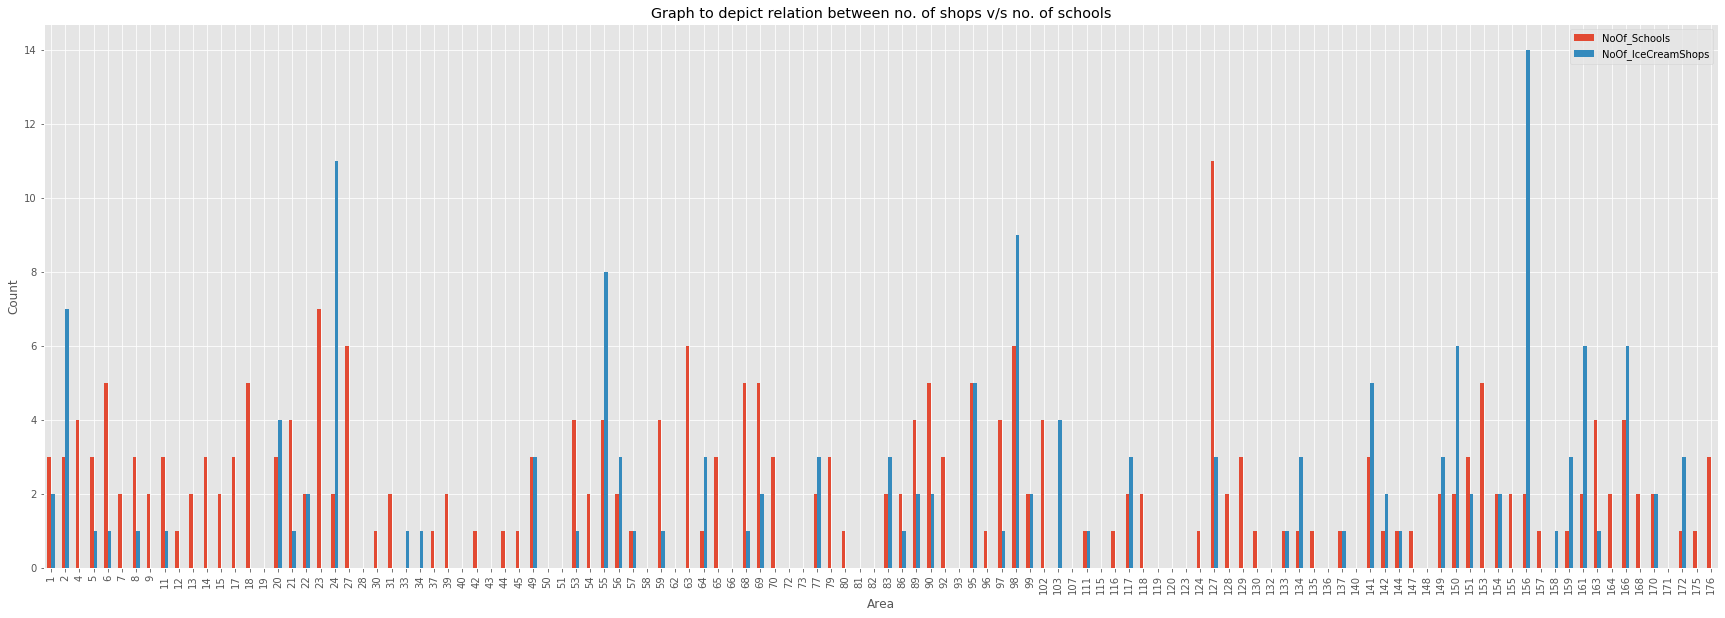

In [214]:
# generate graph to understand the relationship between number of shops v/s schools
df_plot.plot(kind='bar', figsize=(30, 10))

plt.title('Graph to depict relation between no. of shops v/s no. of schools')
plt.ylabel('Count')
plt.xlabel('Area')

plt.show()

## Analysis <a name="analysis"></a>

##### To study the actual relationship, we need to calculate the ratio of Number of Schools with Number of Shops. Let's name it as __Opportunity Ratio__.
##### We will be formulating some rules for avoiding complex calculation
##### 1. If number of Schools == 0 then, ratio will be = 0 
##### 2. If number of Shops == 0 then, ratio will be = 10 * No. of Schools

In [184]:
df_master['OpportunityRatio']=""
for index,row in df_master.iterrows():
    if(row.NoOf_Schools == 0):
        df_master.at[index,'OpportunityRatio'] = 0
    elif(row.NoOf_IceCreamShops == 0):
        df_master.at[index,'OpportunityRatio'] = 10 * row.NoOf_Schools
    else:
        df_master.at[index,'OpportunityRatio'] = row.NoOf_Schools / row.NoOf_IceCreamShops
     

In [197]:
df_master.sort_values('OpportunityRatio', inplace=True, ascending=False)

In [199]:
df_master.head(10)

,Area,Commercial_Rates,Longitude,Latitude,NoOf_Schools,NoOf_IceCreamShops,OpportunityRatio
23,Vittal Mallya Rd,15000.0,77.5948,12.9671,7,0,70
27,Rajaram Mohan Roy Rd,10000.0,77.5968,12.9648,6,0,60
63,HMT Layout,4000.0,77.5921,13.0277,6,0,60
18,Richmond Town,8000.0,77.6042,12.9627,5,0,50
153,Mission Rd,8000.0,77.5969,12.9646,5,0,50
4,Church Street,15000.0,77.6525,12.9743,4,0,40
102,Hennur Rd,3500.0,77.6305,13.0258,4,0,40
79,Sanjaynagar,5000.0,77.5844,13.023,3,0,30
14,Millers Rd,10000.0,77.5892,12.9857,3,0,30
129,Promenade Road,10000.0,77.6178,12.9899,3,0,30


### Data Normalization

##### Finally, any outcome should be affordable thus we need to consider one more factor into consideration

##### Our final decision of choosing the right Area will be based upon two factors 
##### 1. Area with __high Opportunity Ratio__
##### 2. Area with __low Commercial Rate__

For, doing the same we need to normalize both __Commercial_Rates__ and __OpportunityRatio__ so that they are easily comparable. 

Normalization is the process of transforming values of several variables into a similar range. Typical in normalizations value ranges from 0 to 1

In [201]:
#Normalizing master dataframe
df_master['Commercial_Rates'] = df_master['Commercial_Rates']/df_master['Commercial_Rates'].max()
df_master['OpportunityRatio'] = df_master['OpportunityRatio']/df_master['OpportunityRatio'].max()

##### Let's check the result

In [202]:
df_final = df_master[['Area', 'Commercial_Rates','OpportunityRatio']]

In [204]:
df_final.reset_index()
df_final.set_index('Area')

,Commercial_Rates,OpportunityRatio
Area,,
Vittal Mallya Rd,0.60,1
Rajaram Mohan Roy Rd,0.40,0.857143
HMT Layout,0.16,0.857143
Richmond Town,0.32,0.714286
Mission Rd,0.32,0.714286
...,...,...
Chandra Layout,0.16,0
Viveknagar,0.16,0
Kamanahalli,0.16,0


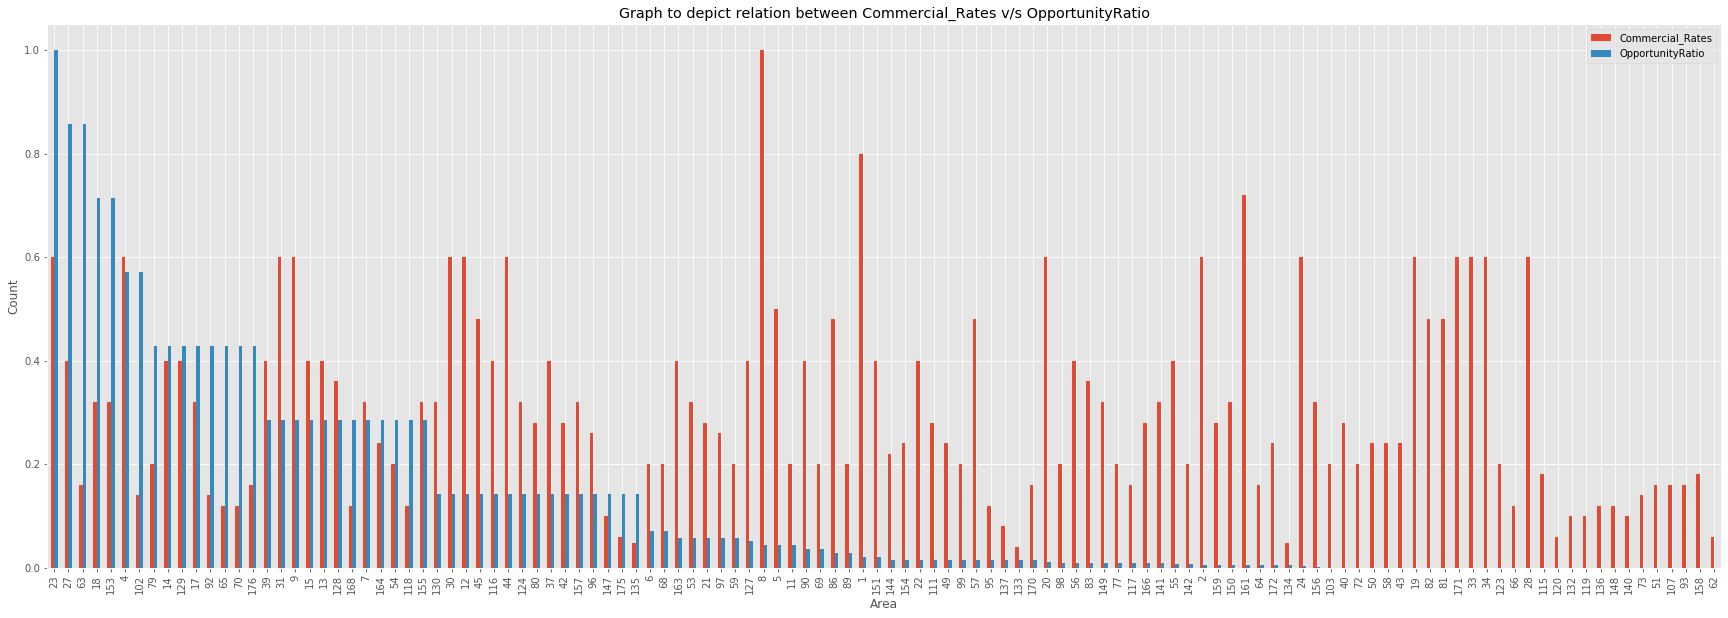

In [207]:
# generate graph to understand the relationship between number of shops v/s schools
df_final.plot(kind='bar', figsize=(30, 10))

plt.title('Graph to depict relation between Commercial_Rates v/s OpportunityRatio')
plt.ylabel('Count')
plt.xlabel('Area')

plt.show()

In [209]:
dt = df_final.sort_values(by=['OpportunityRatio','Commercial_Rates'],  ascending=[False,True])
dt.head(10)

,Area,Commercial_Rates,OpportunityRatio
23,Vittal Mallya Rd,0.60,1
63,HMT Layout,0.16,0.857143
27,Rajaram Mohan Roy Rd,0.40,0.857143
18,Richmond Town,0.32,0.714286
153,Mission Rd,0.32,0.714286
102,Hennur Rd,0.14,0.571429
4,Church Street,0.60,0.571429
65,Jalahalli,0.12,0.428571
70,Sahakarnagar,0.12,0.428571
92,Lingarajpuram,0.14,0.428571


## Results and Discussion <a name="results"></a>

We have started with collecting the data of real estate values of most famous area/neighborhoods in the city of Bangalore. Bangalore is a big city having a large number schools and also ice cream outlets. We have focused our study only on most famous areas and avoided other regions. Thought process behind this decision is to avoid those regions where we expect less profit margins and which have less scope of future growth.

Our study is based upon the thumb rule that, kids and youngsters are more attracted towards ice cream compared to other age groups. So opening a store near to a place where the density of this age group is high will help outlet to maximize its consumer base.

Having said that, on analysing the given dataset we have marked the Areas with maximum potential of growth. We have noticed that area __HMT Layout__ can be potential candidate for our future venture. As, it  possess both the characteristics of high 'Opportunity Ratio' and low industrial cost compare to other areas. There are other options also available for the business person to choose from.

## Conclusion <a name="conclusion"></a>

It is evident from our study that the combination with maximum opportunity ration (i.e. the Area which has a high number of schools to number of ice cream shops ratio) and least expenditure cost will be an ideal choice for the business person to open a new ice cream outlet. 